In [1]:
import os
import numpy as np
import imageio
import cv2
import pandas as pd
face_path = './noise/'
X = []
#如subject02.centerlight，其y_hum为02，y_exp为centerlight
        
for file in os.listdir(face_path):
    im_fn = os.path.join(face_path, file)
    gif = imageio.mimread(im_fn)
    gif = gif[0]
    gif = np.array(gif)
    X.append(gif)
X = np.array(X)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
X = np.array(X)
## flatten
X = X.reshape((X.shape[0], -1))
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt  
from matplotlib.colors import Colormap


In [2]:
X_image=X.reshape(X.shape[0],100,80)

In [3]:
X_image.shape

(164, 100, 80)

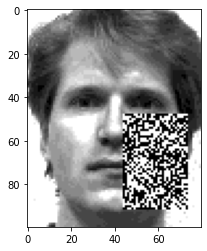

In [4]:
plt.imshow(X_image[4],cmap=plt.cm.gray)

In [5]:
image_array=X_image
Eimage_array=np.zeros_like(image_array[0],dtype=float)
for i in range(len(image_array)):
    Eimage_array+=image_array[i]
Eimage_array/=len(image_array)
image_centered=image_array-Eimage_array

In [7]:
def PCA_2D(image_array):
    Eimage_array=np.zeros_like(image_array[0],dtype=float)
    for i in range(len(image_array)):
        Eimage_array+=image_array[i]
    Eimage_array/=len(image_array)
    image_centered=image_array-Eimage_array
    G_t=np.zeros((image_array[0].shape[1],image_array[0].shape[1]))
    for i in range(len(image_array)):
        G_t+=image_centered[i].T@image_centered[i]
    G_t/=len(image_array)
    w_G_t,v_G_t=np.linalg.eigh(G_t)
    return (w_G_t[::-1],v_G_t[:,::-1])

In [8]:
PCA_2D_L2_eigenvalues,PCA_2D_L2_vector=PCA_2D(X_image)

In [9]:
def PCA_2D_L1_one_dimension(image_centered,max_turn):
    u_t=np.random.rand(image_centered.shape[-1])-0.5
    u_t/=np.sqrt(u_t@u_t.T)
    while True:
        turn_count=0
        tmp=image_centered@u_t
        polarity=np.zeros(image_centered.shape[:2],dtype=int)
        polarity[tmp>0]=1
        polarity[tmp<=0]=-1
        u_t_new=sum([polarity[i]@image_centered[i] for i in range(len(polarity))])
        u_t_new=u_t_new/np.sqrt(u_t_new@u_t_new.T)
        delta=u_t_new-u_t
        if ((delta.max()-delta.min())<1e-5):
            break 
        if turn_count>=max_turn:
            print('Max turn')
            break
        turn_count+=1
        u_t=u_t_new
    return u_t_new

In [10]:
def PCA_2D_L1(image_centerer,max_turn,dimension):
    p_vectors=[PCA_2D_L1_one_dimension(image_centered,max_turn)]
    last_image=image_centered
    for i in range(1,dimension):
        last_v=p_vectors[-1].reshape(last_image.shape[-1],1)
        new_image=last_image-last_image@last_v@last_v.T
        last_image=new_image
        p_vectors.append(PCA_2D_L1_one_dimension(new_image,max_turn))
    return np.array(p_vectors).T

In [26]:
import time
start=time.time()
PCA_2D_L1_vector=PCA_2D_L1(image_centered,50,50)
print(time.time()-start)

23.127685070037842


In [13]:
np.save('PCA_2D_L1_noise.npy',PCA_2D_L1_vector)

In [27]:
pca_1D=PCA(n_components=50)
pca_1D.fit(image_centered.reshape(X.shape[0],-1))
image_1D_pc=pca_1D.transform(image_centered.reshape(X.shape[0],-1))
PCA_1D_L2_vectors=pca_1D.components_.T

In [15]:
def error(image_centered,projection_matrix):
    tmp=0
    for i in image_centered:
        tmp+=np.sqrt(np.square(i-i@projection_matrix@projection_matrix.T).sum())
    tmp/=image_centered.shape[0]
    return tmp

In [30]:
error_PCA_2D_L2=[error(image_centered,PCA_2D_L2_vector[:,:i]) for i in range(1,51)]

In [31]:
error_PCA_2D_L1=[error(image_centered,PCA_2D_L1_vector[:,:i]) for i in range(1,51)]

In [32]:
error_PCA_L2=[error(image_centered.reshape(image_centered.shape[0],-1),PCA_1D_L2_vectors[:,:i]) for i in range(1,51)]

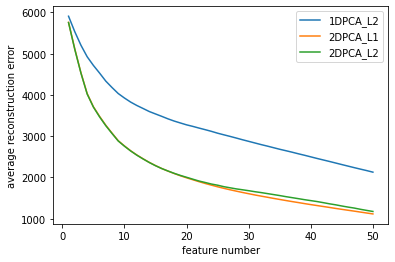

In [37]:
plt.plot(range(1,51),error_PCA_L2[:50])
plt.plot(range(1,51),error_PCA_2D_L1[:50])
plt.plot(range(1,51),error_PCA_2D_L2[:50])
plt.xlabel('feature number')
plt.ylabel('average reconstruction error')
plt.legend(['1DPCA_L2','2DPCA_L1', '2DPCA_L2'])
plt.show()